In [1]:
from transformer4 import Transformer
from add_noise import DataAugmentor
import time
import os
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_text
import editdistance

2024-12-19 20:09:15.921922: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-19 20:09:16.163835: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-19 20:09:16.163896: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-19 20:09:16.199849: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-19 20:09:16.281029: I tensorflow/core/platform/cpu_feature_guar

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

2024-11-30 16:15:25.353525: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


### Set up the tokenizer

In [3]:
model_name = 'armenian_tokenizer'
tokenizer = tf.saved_model.load(model_name).am

In [4]:
with open("/home/vahan/Documents/machine_translation/training_data_paired", "rb") as f:
    training_data_paired = pickle.load(f)

In [ ]:
# with open("test_data_paired.pkl", "rb") as f:
#     test_data_paired = pickle.load(f)

In [5]:
keysList = list(training_data_paired.keys())
valuesList = list(training_data_paired.values())

In [6]:
# Step 2: Convert data to tensors
data_tensors = tf.convert_to_tensor(keysList)
labels_tensors = tf.convert_to_tensor(valuesList)

# Step 3: Create tuples of tensors
data_tuples = tf.data.Dataset.from_tensor_slices((data_tensors, labels_tensors))

# Step 4: Construct PrefetchDataset
prefetch_dataset = data_tuples.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [7]:
dataset_size = len(prefetch_dataset)
dataset_size

1681034

In [8]:
train_size = int(0.9 * dataset_size)
val_size = dataset_size - train_size

# Shuffle the dataset
dataset = prefetch_dataset.shuffle(buffer_size=dataset_size, reshuffle_each_iteration=False)

# Split the dataset
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)


# Prefetch the datasets
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


In [9]:
len(train_dataset), len(val_dataset)

(1512930, 168104)

### Set up a data pipeline with `tf.data`

In [10]:
MAX_TOKENS=65
def prepare_batch(input, output):
    
    input = tokenizer.tokenize(input)      # Output is ragged.
    input = input[:, :MAX_TOKENS]    # Trim to MAX_TOKENS.
    input = input.to_tensor()  # Convert to 0-padded dense Tensor

    
    output = tokenizer.tokenize(output)
    output = output[:, :(MAX_TOKENS+1)]
    decoder_inputs = output[:, :-1].to_tensor()  # Drop the [END] tokens
    targets = output[:, 1:].to_tensor()   # Drop the [START] tokens
    

    return (input, decoder_inputs), targets

In [11]:
BUFFER_SIZE = 5000
BATCH_SIZE = 1024

In [12]:
def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

## Test the Dataset 

In [13]:
# Create training and validation set batches.
train_batches = make_batches(train_dataset)
val_batches = make_batches(val_dataset)

In [14]:
num_layers = 1
d_model = 110
dff = 1024
num_heads = 5
dropout_rate = 0.15

In [15]:
transformer = Transformer(
    # encoder_num_layers=encoder_num_layers,
    # decoder_num_layers=decoder_num_layers,
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizer.get_vocab_size().numpy(),
    target_vocab_size=tokenizer.get_vocab_size().numpy(),
    dropout_rate=dropout_rate)

In [16]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [17]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

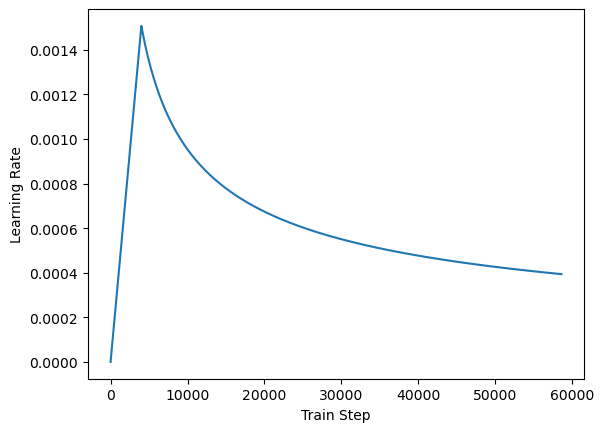

In [18]:
plt.plot(learning_rate(tf.range(58600, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

In [19]:
def masked_loss(label, pred):
    mask = label != 0
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_object(label, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss



def cer(label, pred):
    # Convert predicted logits to character indices
    pred_indices = tf.argmax(pred, axis=2)

    label = tf.cast(label, tf.int64)
    pred_indices = tf.cast(pred_indices, tf.int64)

    # Detokenize label and predicted indices to get string tensors
    label_str = str(tokenizer.detokenize(label))
    pred_str = str(tokenizer.detokenize(pred_indices))


    # Compute the edit distance
    distance = editdistance.eval(pred_str, label_str)

    # Compute the length of each label string (ignoring padding)
    label_len = tf.reduce_sum(tf.cast(label != 0, dtype=tf.int32), axis=-1)

    # Calculate CER
    cer = distance / tf.cast(label_len, tf.float32)

    # Return the mean CER over the batch
    return tf.reduce_mean(cer)


def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != 0

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [22]:
log_dir = "logs/fit/" + "d_model110_dff1024_numhead5_numlayer1_bs1024_maxtoken_65_dropout_rate_015_multi_query"
checkpoint_dir = "d_model110_dff1024_numhead5_numlayer1_bs1024_maxtoken_65_dropout_rate_015_multi_query/cp.ckpt"

In [26]:
my_callbacks = transformer.get_callbacks(logdir=log_dir, checkpoint=checkpoint_dir, verbose=1)

ValueError: When using `save_weights_only=True` in `ModelCheckpoint`, the filepath provided must end in `.weights.h5` (Keras weights format). Received: filepath=d_model110_dff1024_numhead5_numlayer1_bs1024_maxtoken_65_dropout_rate_015_multi_query/cp.ckpt

In [23]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy, cer])

In [24]:
transformer_model = transformer.build_model(input_shape=(None,), target_shape=(None,))
transformer_model.summary()

/home/vahan/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/vahan/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/vahan/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/vah

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ context_input       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ target_input        │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder (Encoder)   │ (None, None, 110) │  3,678,874 │ context_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder (Decoder)   │ (None, None, 110) │  3,922,854 │ target_input[0][… │
│                     │                   │            │ encoder[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, None,      │  3,237,426 │ decoder[0][0]     │
│                     │ 29166)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,839,154 (41.35 MB)

 Trainable params: 10,839,154 (41.35 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# transformer.load_weights(checkpoint_dir)

In [25]:
transformer.fit(train_batches,
                epochs=20,
                validation_data=val_batches)
                # callbacks=[my_callbacks])

Epoch 1/20


2024-11-15 20:44:10.219977: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT64 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
/home/vahan/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/vahan/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/vahan/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'value' (of type EinsumDense) was passed an input w

Test the custom learning rate scheduler:

## Run inference

In [ ]:
class Corrector(tf.Module):
  def __init__(self, tokenizer, transformer):
    self.tokenizer = tokenizer
    self.transformer = transformer
    


  def __call__(self, sentence, max_length=MAX_TOKENS):
    # The input sentence is Portuguese, hence adding the `[START]` and `[END]` tokens.
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizer.tokenize(sentence).to_tensor()
    
    encoder_input = sentence

    # As the output language is English, initialize the output with the
    # English `[START]` token.
    start_end = self.tokenizer.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # `tf.TensorArray` is required here (instead of a Python list), so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)
    
    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions = self.transformer([encoder_input, output], training=False)

      # Select the last token from the `seq_len` dimension.
      predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

      predicted_id = tf.argmax(predictions, axis=-1)

      # Concatenate the `predicted_id` to the output which is given to the
      # decoder as its input.
      
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # The output shape is `(1, tokens)`.
    text = tokenizer.detokenize(output)[0]  # Shape: `()`.

    tokens = tokenizer.lookup(output)[0]
    
    
    
    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop.
    # So, recalculate them outside the loop.
    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    return text, tokens, attention_weights


Note: This function uses an unrolled loop, not a dynamic loop. It generates `MAX_TOKENS` on every call. Refer to the [NMT with attention](nmt_with_attention.ipynb) tutorial for an example implementation with a dynamic loop, which can be much more efficient.

Create an instance of this `Translator` class, and try it out a few times:

In [ ]:
translator = Corrector(tokenizer, transformer)

In [ ]:
def print_correction(sentence, tokens, ground_truth):
    print(f'{"Input:":15s}: {sentence}')
    print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
    print(f'{"Ground truth":15s}: {ground_truth}')

In [ ]:
import re

class Preprocessing:
    def __init__(self, normalized_transcription, char_set = None, list_of_words = None):
        self.normalized_transcription = normalized_transcription
        #         self.new_sentences = set()
        self.new_sentences = list()
    def performe_preprocessing(self):
        pattern = r'.*\d.*'
        new_data = [sentence for sentence in self.normalized_transcription if not re.match(pattern, sentence)]
        self.normalized_transcription = new_data
        if " " in self.normalized_transcription:
            self.normalized_transcription.remove(" ")
        for sent in self.normalized_transcription:
            sent = sent.lower()
            new_sent = ""
            for i in sent:
                if ord(i) in range(ord("ա"), ord("և")+1) or i in {",", "։", " ", ":", ","}:
                    new_sent += i

            new_sent = new_sent.lower()

            if len(new_sent.strip())>1:
                if ":" in new_sent:
                    new_sent = new_sent.replace(":", "։")
                if new_sent[-1] == "։":
                    new_sent = new_sent.replace("։", "")
                new_sent = new_sent.replace("եվ", "և")
                new_sent = new_sent.replace("։", " ։")
                new_sent = new_sent.replace(",", ",")
                new_sent = new_sent.replace(",", " ,")
                new_sent = new_sent.replace(",", ", ")
                new_sent = " ".join(new_sent.split())

                self.new_sentences.append(new_sent)
        return self.new_sentences

In [ ]:
sentence = 'հհբնապահպանության նախարարը մասնակցել է շրջակա միջաայրհի և քլիմաիփոփոխությւնների վչերաբերյալ եգմ և արիևելյան գործընկերության երկրներինախարարշցների առաճհիմհանդպմանը'

ground_truth = "հհ բնապահպանության նախարարը մասնակցել է շրջակա միջավայրի և կլիմայի փոփոխությունների վերաբերյալ եմ և արևելյան գործընկերության երկրների նախարարների առաջին հանդիպմանը"

print("բառերի քանակը", len(sentence.split()))
print("տոկենների քանակը", tokenizer.tokenize(tf.constant([sentence]))[0].shape[0])

prp = Preprocessing(normalized_transcription=[sentence])
filtered_sentence = prp.performe_preprocessing()

start_time = time.time()

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(filtered_sentence))

end_time = time.time()
inference_time = end_time - start_time

print(f"Inference time: {inference_time:.4f} seconds")

print_correction(sentence, translated_text, ground_truth)